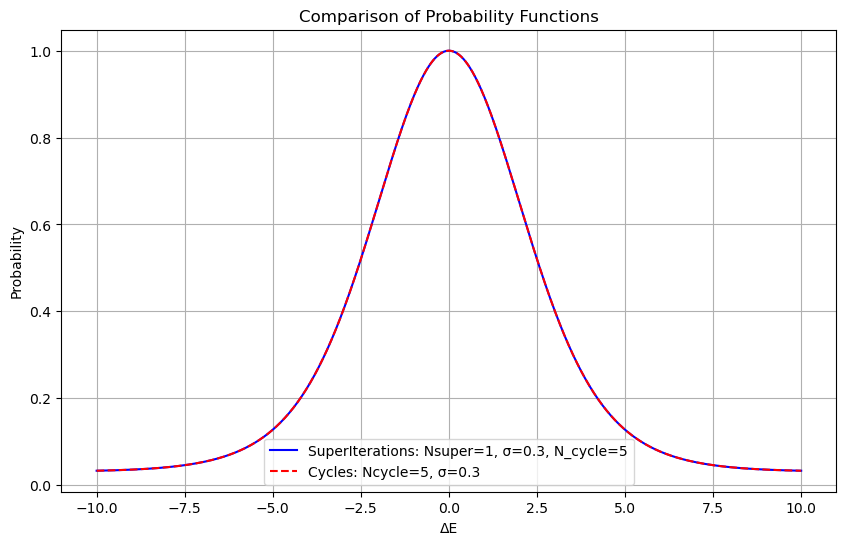

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_probability1(delta_E, Nsuper, sigma, N_cycle):
    prob = 0
    for n in range(2**Nsuper + 1):
        term = (1 / 2**(2*Nsuper-1)) * (2**Nsuper - n)
        exponent = -(delta_E**2 * sigma**2 * n**2) / (2**(2*Nsuper-1))
        prob += term * np.exp(exponent)
    base_prob = prob - 1/2**Nsuper
    return base_prob**N_cycle

def calculate_probability2(delta_E, sigma, N):
    return ((1 + np.exp(-(delta_E**2) * sigma**2 / 2)) / 2)**N

def plot_both_probabilities(Nsuper, sigma1, sigma2,  Ncyclesuper, Ncycle):
    delta_E = np.linspace(-10, 10, 1000)
    probs1 = [calculate_probability1(de, Nsuper, sigma1, Ncyclesuper) for de in delta_E]
    probs2 = [calculate_probability2(de, sigma2, Ncycle) for de in delta_E]
    
    plt.figure(figsize=(10, 6))
    plt.plot(delta_E, probs1, 'b-', label=f'SuperIterations: Nsuper={Nsuper}, σ={sigma1}, N_cycle={Ncyclesuper}')
    plt.plot(delta_E, probs2, 'r--', label=f'Cycles: Ncycle={Ncycle}, σ={sigma2}')
    plt.xlabel('ΔE')
    plt.ylabel('Probability')
    plt.title('Comparison of Probability Functions')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
Nsuper = 1
sigma1 = 0.3
sigma2 = 0.3
N_cyclesuper = 5
N_cycle = 5

plot_both_probabilities(Nsuper, sigma1, sigma2, N_cyclesuper, N_cycle)

C:\Users\sirac\AppData\Local\Temp\ipykernel_44344\2413075422.py:73: RuntimeWarning: divide by zero encountered in divide
  Ns = (2 * T / Nc) - 2



Optimal Parameters:
Ncycle: 9.000
Nsuper: 2.000
FWHM: 2.032
Total Time: 18.000
Peak Height: 1.000


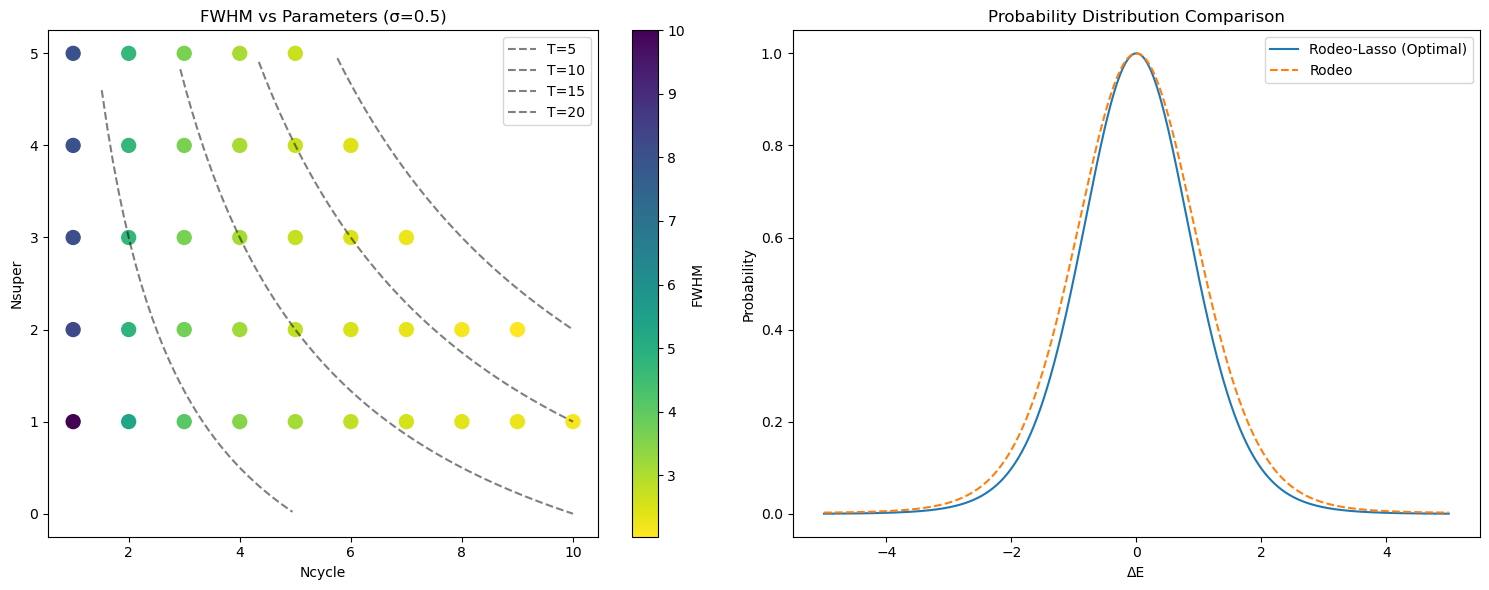

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

def rodeo_probability(delta_E, sigma, Ncycle):
    return ((1 + np.exp(-(delta_E**2) * sigma**2 / 2)) / 2)**Ncycle

def rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper):
    prob = 0
    for n in range(2**Nsuper + 1):
        term = (1 / 2**(2*Nsuper-1)) * (2**Nsuper - n)
        exponent = -(delta_E**2 * sigma**2 * n**2) / (2**(2*Nsuper-1))
        prob += term * np.exp(exponent)
    base_prob = prob - 1/2**Nsuper
    return base_prob**Ncycle

def calculate_fwhm(x, y):
    half_max = np.max(y) / 2
    # Find indices where the curve crosses half maximum
    indices = np.where(y >= half_max)[0]
    if len(indices) > 0:
        return x[indices[-1]] - x[indices[0]]
    return np.inf

def parameter_sweep(sigma, max_Ncycle, max_Nsuper, time_constraint=20):
    # Set up energy range
    delta_E = np.linspace(-5, 5, 1000)
    
    # Arrays to store results
    Ncycles = []
    Nsupers = []
    FWHMs = []
    total_times = []
    peak_heights = []
    
    # Perform parameter sweep
    for Ncycle in range(1, max_Ncycle + 1):
        for Nsuper in range(1, max_Nsuper + 1):
            # Calculate total time
            total_time = Ncycle * (1 + Nsuper/2)
            
            if total_time < time_constraint:
                # Calculate FWHM for rodeo-lasso
                p_lasso = rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper)
                fwhm_lasso = calculate_fwhm(delta_E, p_lasso)
                
                Ncycles.append(Ncycle)
                Nsupers.append(Nsuper)
                FWHMs.append(fwhm_lasso)
                total_times.append(total_time)
                peak_heights.append(np.max(p_lasso))
    
    return np.array(Ncycles), np.array(Nsupers), np.array(FWHMs), np.array(total_times), np.array(peak_heights)

def plot_parameter_sweep(sigma=1.0, max_Ncycle=10, max_Nsuper=5):
    # Perform parameter sweep
    Ncycles, Nsupers, FWHMs, total_times, peak_heights = parameter_sweep(sigma, max_Ncycle, max_Nsuper)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot of FWHM
    scatter = ax1.scatter(Ncycles, Nsupers, c=FWHMs, s=100, cmap='viridis_r')
    ax1.set_xlabel('Ncycle')
    ax1.set_ylabel('Nsuper')
    ax1.set_title(f'FWHM vs Parameters (σ={sigma})')
    plt.colorbar(scatter, ax=ax1, label='FWHM')
    
    # Add time constraint contours
    Nc = np.linspace(0, max_Ncycle, 100)
    for T in [5, 10, 15, 20]:
        Ns = (2 * T / Nc) - 2
        mask = (Ns >= 0) & (Ns <= max_Nsuper)
        ax1.plot(Nc[mask], Ns[mask], '--', color='black', alpha=0.5, label=f'T={T}')
    ax1.legend()
    
    # Find and print optimal parameters
    min_fwhm_idx = np.argmin(FWHMs)
    best_params = {
        'Ncycle': Ncycles[min_fwhm_idx],
        'Nsuper': Nsupers[min_fwhm_idx],
        'FWHM': FWHMs[min_fwhm_idx],
        'Total Time': total_times[min_fwhm_idx],
        'Peak Height': peak_heights[min_fwhm_idx]
    }
    
    # Plot probability distributions for optimal parameters
    delta_E = np.linspace(-5, 5, 1000)
    p_lasso_opt = rodeo_lasso_probability(delta_E, sigma, best_params['Ncycle'], best_params['Nsuper'])
    p_rodeo = rodeo_probability(delta_E, sigma, best_params['Ncycle'])
    
    ax2.plot(delta_E, p_lasso_opt, label='Rodeo-Lasso (Optimal)')
    ax2.plot(delta_E, p_rodeo, '--', label='Rodeo')
    ax2.set_xlabel('ΔE')
    ax2.set_ylabel('Probability')
    ax2.set_title('Probability Distribution Comparison')
    ax2.legend()
    
    plt.tight_layout()
    
    # Print optimal parameters
    print("\nOptimal Parameters:")
    for key, value in best_params.items():
        print(f"{key}: {value:.3f}")
    
    return fig, best_params

# Run the analysis
if __name__ == "__main__":
    fig, best_params = plot_parameter_sweep(sigma=0.5, max_Ncycle=10, max_Nsuper=5)
    plt.show()

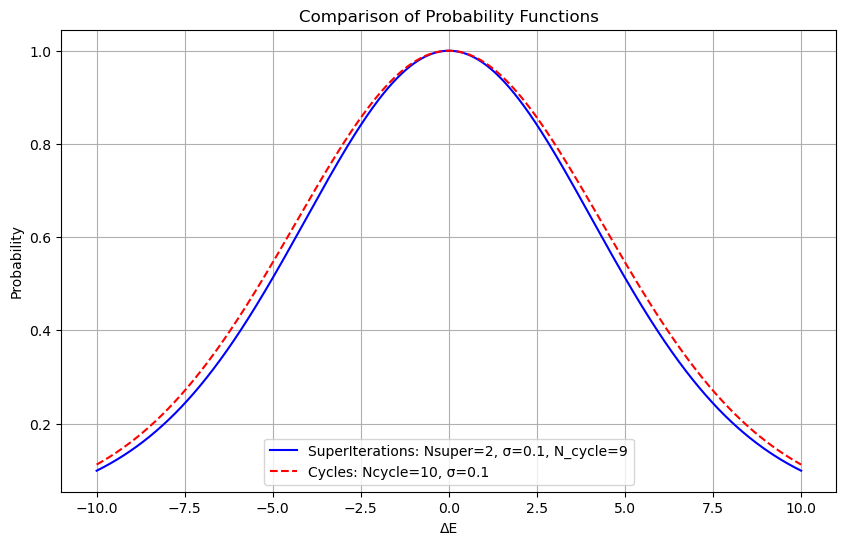

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_probability1(delta_E, Nsuper, sigma, N_cycle):
    prob = 0
    for n in range(2**Nsuper + 1):
        term = (1 / 2**(2*Nsuper-1)) * (2**Nsuper - n)
        exponent = -(delta_E**2 * sigma**2 * n**2) / (2**(2*Nsuper-1))
        prob += term * np.exp(exponent)
    base_prob = prob - 1/2**Nsuper
    return base_prob**N_cycle

def calculate_probability2(delta_E, sigma, N):
    return ((1 + np.exp(-(delta_E**2) * sigma**2 / 2)) / 2)**N

def plot_both_probabilities(Nsuper, sigma1, sigma2,  Ncyclesuper, Ncycle):
    delta_E = np.linspace(-10, 10, 1000)
    probs1 = [calculate_probability1(de, Nsuper, sigma1, Ncyclesuper) for de in delta_E]
    probs2 = [calculate_probability2(de, sigma2, Ncycle) for de in delta_E]
    
    plt.figure(figsize=(10, 6))
    plt.plot(delta_E, probs1, 'b-', label=f'SuperIterations: Nsuper={Nsuper}, σ={sigma1}, N_cycle={Ncyclesuper}')
    plt.plot(delta_E, probs2, 'r--', label=f'Cycles: Ncycle={Ncycle}, σ={sigma2}')
    plt.xlabel('ΔE')
    plt.ylabel('Probability')
    plt.title('Comparison of Probability Functions')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
Nsuper = 2
sigma1 = 0.1
sigma2 = 0.1
N_cyclesuper = 9
N_cycle = 10

plot_both_probabilities(Nsuper, sigma1, sigma2, N_cyclesuper, N_cycle)

C:\Users\sirac\AppData\Local\Temp\ipykernel_44344\2472369747.py:73: RuntimeWarning: divide by zero encountered in divide
  Ns = (2 * T / Nc) - 2



Optimal Parameters:
Ncycle: 9.000
Nsuper: 2.000
FWHM: 1.011
Total Time: 18.000
Peak Height: 1.000


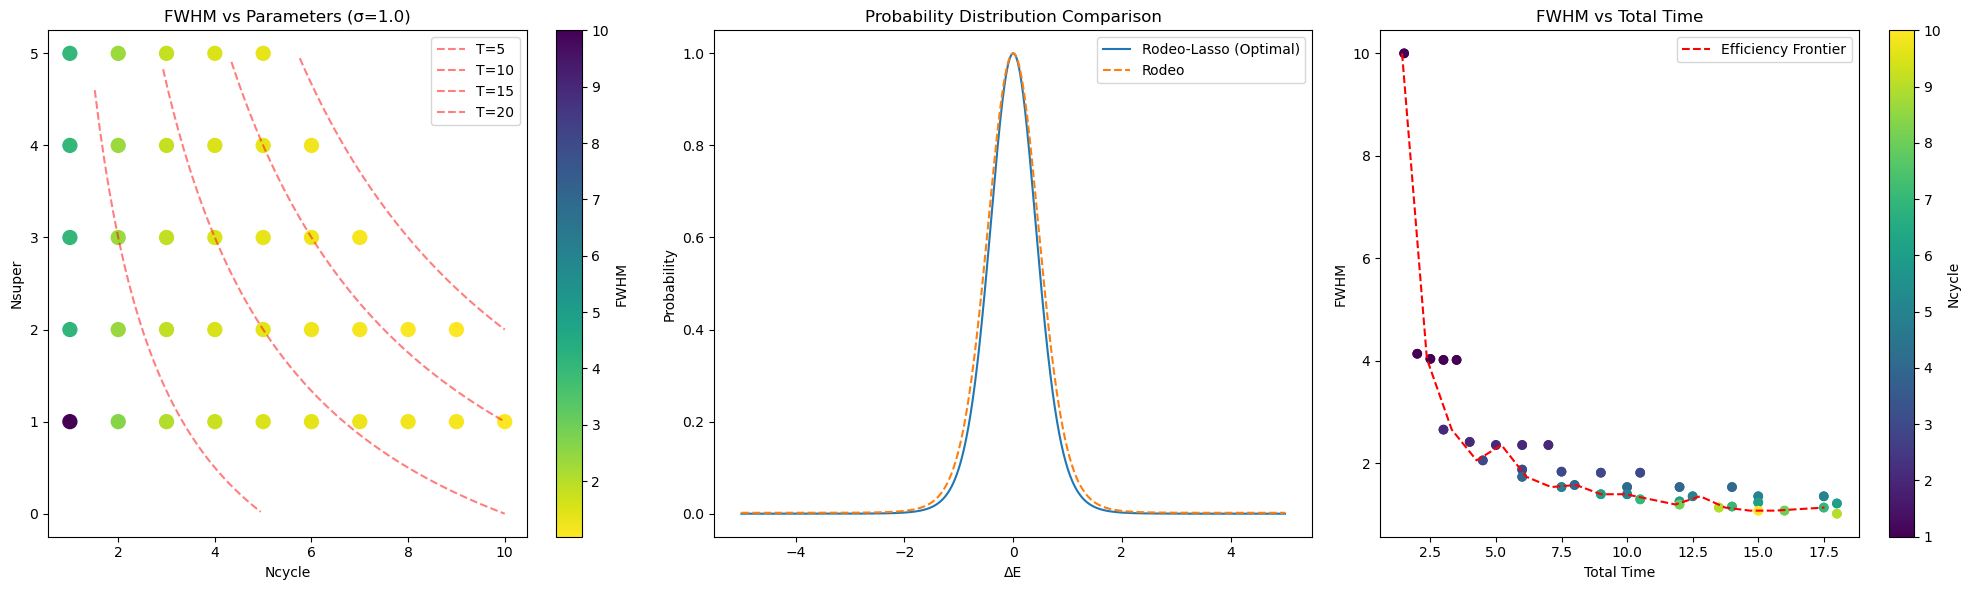

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

def rodeo_probability(delta_E, sigma, Ncycle):
    return ((1 + np.exp(-(delta_E**2) * sigma**2 / 2)) / 2)**Ncycle

def rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper):
    prob = 0
    for n in range(2**Nsuper + 1):
        term = (1 / 2**(2*Nsuper-1)) * (2**Nsuper - n)
        exponent = -(delta_E**2 * sigma**2 * n**2) / (2**(2*Nsuper-1))
        prob += term * np.exp(exponent)
    base_prob = prob - 1/2**Nsuper
    return base_prob**Ncycle

def calculate_fwhm(x, y):
    half_max = np.max(y) / 2
    # Find indices where the curve crosses half maximum
    indices = np.where(y >= half_max)[0]
    if len(indices) > 0:
        return x[indices[-1]] - x[indices[0]]
    return np.inf

def parameter_sweep(sigma, max_Ncycle, max_Nsuper, time_constraint=20):
    # Set up energy range
    delta_E = np.linspace(-5, 5, 1000)
    
    # Arrays to store results
    Ncycles = []
    Nsupers = []
    FWHMs = []
    total_times = []
    peak_heights = []
    
    # Perform parameter sweep
    for Ncycle in range(1, max_Ncycle + 1):
        for Nsuper in range(1, max_Nsuper + 1):
            # Calculate total time
            total_time = Ncycle * (1 + Nsuper/2)
            
            if total_time < time_constraint:
                # Calculate FWHM for rodeo-lasso
                p_lasso = rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper)
                fwhm_lasso = calculate_fwhm(delta_E, p_lasso)
                
                Ncycles.append(Ncycle)
                Nsupers.append(Nsuper)
                FWHMs.append(fwhm_lasso)
                total_times.append(total_time)
                peak_heights.append(np.max(p_lasso))
    
    return np.array(Ncycles), np.array(Nsupers), np.array(FWHMs), np.array(total_times), np.array(peak_heights)

def plot_parameter_sweep(sigma=1.0, max_Ncycle=10, max_Nsuper=5):
    # Perform parameter sweep
    Ncycles, Nsupers, FWHMs, total_times, peak_heights = parameter_sweep(sigma, max_Ncycle, max_Nsuper)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Scatter plot of FWHM
    scatter = ax1.scatter(Ncycles, Nsupers, c=FWHMs, s=100, cmap='viridis_r')
    ax1.set_xlabel('Ncycle')
    ax1.set_ylabel('Nsuper')
    ax1.set_title(f'FWHM vs Parameters (σ={sigma})')
    plt.colorbar(scatter, ax=ax1, label='FWHM')
    
    # Add time constraint contours
    Nc = np.linspace(0, max_Ncycle, 100)
    for T in [5, 10, 15, 20]:
        Ns = (2 * T / Nc) - 2
        mask = (Ns >= 0) & (Ns <= max_Nsuper)
        ax1.plot(Nc[mask], Ns[mask], '--', color='red', alpha=0.5, label=f'T={T}')
    ax1.legend()
    
    # Find and print optimal parameters
    min_fwhm_idx = np.argmin(FWHMs)
    best_params = {
        'Ncycle': Ncycles[min_fwhm_idx],
        'Nsuper': Nsupers[min_fwhm_idx],
        'FWHM': FWHMs[min_fwhm_idx],
        'Total Time': total_times[min_fwhm_idx],
        'Peak Height': peak_heights[min_fwhm_idx]
    }
    
    # Plot probability distributions for optimal parameters
    delta_E = np.linspace(-5, 5, 1000)
    p_lasso_opt = rodeo_lasso_probability(delta_E, sigma, best_params['Ncycle'], best_params['Nsuper'])
    p_rodeo = rodeo_probability(delta_E, sigma, best_params['Ncycle'])
    
    ax2.plot(delta_E, p_lasso_opt, label='Rodeo-Lasso (Optimal)')
    ax2.plot(delta_E, p_rodeo, '--', label='Rodeo')
    ax2.set_xlabel('ΔE')
    ax2.set_ylabel('Probability')
    ax2.set_title('Probability Distribution Comparison')
    ax2.legend()
    
    # Plot FWHM vs Total Time
    ax3.scatter(total_times, FWHMs, c=Ncycles, cmap='viridis')
    ax3.set_xlabel('Total Time')
    ax3.set_ylabel('FWHM')
    ax3.set_title('FWHM vs Total Time')
    scatter2 = ax3.scatter(total_times, FWHMs, c=Ncycles, cmap='viridis')
    plt.colorbar(scatter2, ax=ax3, label='Ncycle')
    
    # Add efficiency frontier line
    # For each total time bin, find the minimum FWHM
    time_bins = np.linspace(0, max(total_times), 20)
    min_fwhms = []
    bin_centers = []
    
    for i in range(len(time_bins)-1):
        mask = (total_times >= time_bins[i]) & (total_times < time_bins[i+1])
        if np.any(mask):
            min_fwhms.append(np.min(FWHMs[mask]))
            bin_centers.append((time_bins[i] + time_bins[i+1])/2)
    
    ax3.plot(bin_centers, min_fwhms, 'r--', label='Efficiency Frontier')
    ax3.legend()
    
    plt.tight_layout()
    
    # Print optimal parameters
    print("\nOptimal Parameters:")
    for key, value in best_params.items():
        print(f"{key}: {value:.3f}")
    
    return fig, best_params

# Run the analysis
if __name__ == "__main__":
    fig, best_params = plot_parameter_sweep(sigma=1.0, max_Ncycle=10, max_Nsuper=5)
    plt.show()

C:\Users\sirac\AppData\Local\Temp\ipykernel_44344\1714892702.py:67: RuntimeWarning: divide by zero encountered in divide
  Ns = (2 * T / Nc) - 2



Optimal Parameters:
Ncycle: 15.000
Nsuper: 3.000
FWHM: 0.751
Total Time: 37.500
Peak Height: 1.000


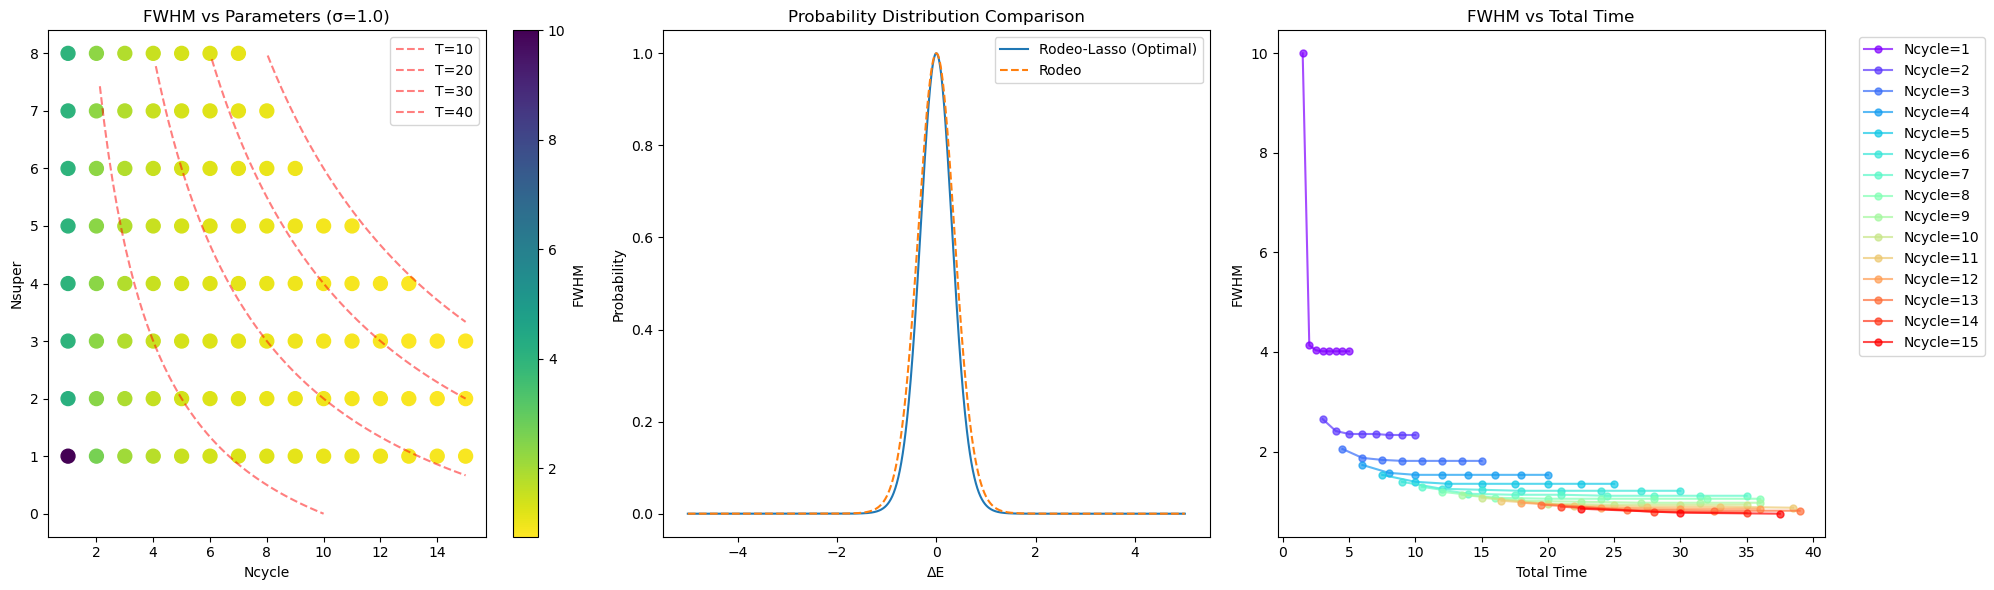

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

def rodeo_probability(delta_E, sigma, Ncycle):
    return ((1 + np.exp(-(delta_E**2) * sigma**2 / 2)) / 2)**Ncycle

def rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper):
    prob = 0
    for n in range(2**Nsuper + 1):
        term = (1 / 2**(2*Nsuper-1)) * (2**Nsuper - n)
        exponent = -(delta_E**2 * sigma**2 * n**2) / (2**(2*Nsuper-1))
        prob += term * np.exp(exponent)
    base_prob = prob - 1/2**Nsuper
    return base_prob**Ncycle

def calculate_fwhm(x, y):
    half_max = np.max(y) / 2
    indices = np.where(y >= half_max)[0]
    if len(indices) > 0:
        return x[indices[-1]] - x[indices[0]]
    return np.inf

def parameter_sweep(sigma, max_Ncycle, max_Nsuper, time_constraint=40):
    delta_E = np.linspace(-5, 5, 1000)
    
    Ncycles = []
    Nsupers = []
    FWHMs = []
    total_times = []
    peak_heights = []
    
    for Ncycle in range(1, max_Ncycle + 1):
        for Nsuper in range(1, max_Nsuper + 1):
            total_time = Ncycle * (1 + Nsuper/2)
            
            if total_time < time_constraint:
                p_lasso = rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper)
                fwhm_lasso = calculate_fwhm(delta_E, p_lasso)
                
                Ncycles.append(Ncycle)
                Nsupers.append(Nsuper)
                FWHMs.append(fwhm_lasso)
                total_times.append(total_time)
                peak_heights.append(np.max(p_lasso))
    
    return np.array(Ncycles), np.array(Nsupers), np.array(FWHMs), np.array(total_times), np.array(peak_heights)

def plot_parameter_sweep(sigma=1.0, max_Ncycle=15, max_Nsuper=8):
    # Perform parameter sweep
    Ncycles, Nsupers, FWHMs, total_times, peak_heights = parameter_sweep(sigma, max_Ncycle, max_Nsuper)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Scatter plot of FWHM
    scatter = ax1.scatter(Ncycles, Nsupers, c=FWHMs, s=100, cmap='viridis_r')
    ax1.set_xlabel('Ncycle')
    ax1.set_ylabel('Nsuper')
    ax1.set_title(f'FWHM vs Parameters (σ={sigma})')
    plt.colorbar(scatter, ax=ax1, label='FWHM')
    
    # Add time constraint contours
    Nc = np.linspace(0, max_Ncycle, 100)
    for T in [10, 20, 30, 40]:
        Ns = (2 * T / Nc) - 2
        mask = (Ns >= 0) & (Ns <= max_Nsuper)
        ax1.plot(Nc[mask], Ns[mask], '--', color='red', alpha=0.5, label=f'T={T}')
    ax1.legend()
    
    # Find and print optimal parameters
    min_fwhm_idx = np.argmin(FWHMs)
    best_params = {
        'Ncycle': Ncycles[min_fwhm_idx],
        'Nsuper': Nsupers[min_fwhm_idx],
        'FWHM': FWHMs[min_fwhm_idx],
        'Total Time': total_times[min_fwhm_idx],
        'Peak Height': peak_heights[min_fwhm_idx]
    }
    
    # Plot probability distributions for optimal parameters
    delta_E = np.linspace(-5, 5, 1000)
    p_lasso_opt = rodeo_lasso_probability(delta_E, sigma, best_params['Ncycle'], best_params['Nsuper'])
    p_rodeo = rodeo_probability(delta_E, sigma, best_params['Ncycle'])
    
    ax2.plot(delta_E, p_lasso_opt, label='Rodeo-Lasso (Optimal)')
    ax2.plot(delta_E, p_rodeo, '--', label='Rodeo')
    ax2.set_xlabel('ΔE')
    ax2.set_ylabel('Probability')
    ax2.set_title('Probability Distribution Comparison')
    ax2.legend()
    
    # Plot FWHM vs Total Time with different colors for each Ncycle
    unique_Ncycles = np.unique(Ncycles)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_Ncycles)))
    
    for i, nc in enumerate(unique_Ncycles):
        mask = Ncycles == nc
        ax3.plot(total_times[mask], FWHMs[mask], 'o-', 
                label=f'Ncycle={nc}', color=colors[i], 
                markersize=5, alpha=0.7)
    
    ax3.set_xlabel('Total Time')
    ax3.set_ylabel('FWHM')
    ax3.set_title('FWHM vs Total Time')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    # Print optimal parameters
    print("\nOptimal Parameters:")
    for key, value in best_params.items():
        print(f"{key}: {value:.3f}")
    
    return fig, best_params

# Run the analysis
if __name__ == "__main__":
    fig, best_params = plot_parameter_sweep(sigma=1.0, max_Ncycle=15, max_Nsuper=8)
    plt.show()

C:\Users\sirac\AppData\Local\Temp\ipykernel_44344\2465105248.py:70: RuntimeWarning: divide by zero encountered in divide
  Ns = (2 * T / Nc) - 2



Optimal Parameters:
Ncycle: 15.000
Nsuper: 3.000
FWHM: 0.751
Total Time: 37.500
Peak Height: 1.000


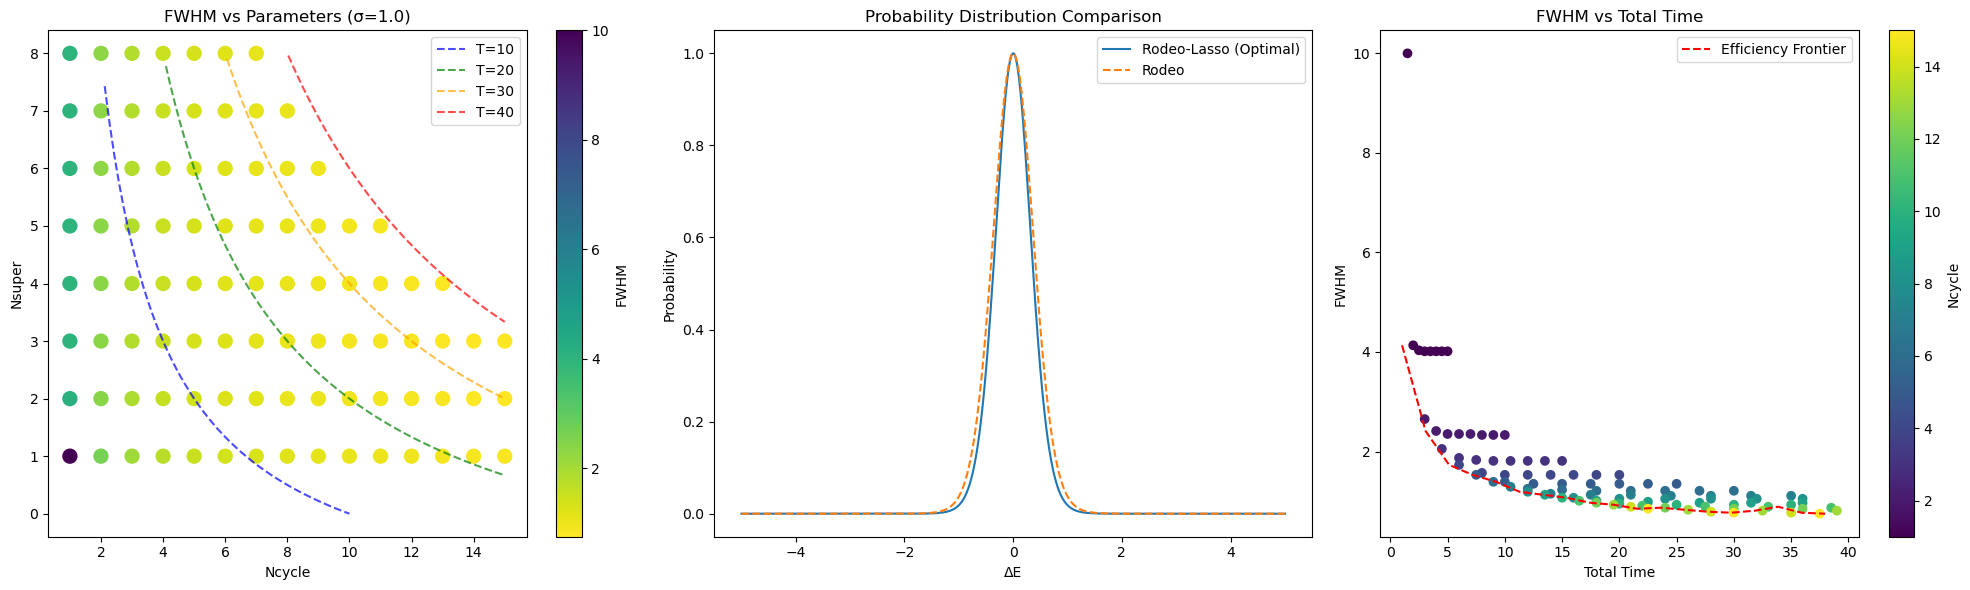

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

def rodeo_probability(delta_E, sigma, Ncycle):
    return ((1 + np.exp(-(delta_E**2) * sigma**2 / 2)) / 2)**Ncycle

def rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper):
    prob = 0
    for n in range(2**Nsuper + 1):
        term = (1 / 2**(2*Nsuper-1)) * (2**Nsuper - n)
        exponent = -(delta_E**2 * sigma**2 * n**2) / (2**(2*Nsuper-1))
        prob += term * np.exp(exponent)
    base_prob = prob - 1/2**Nsuper
    return base_prob**Ncycle

def calculate_fwhm(x, y):
    half_max = np.max(y) / 2
    indices = np.where(y >= half_max)[0]
    if len(indices) > 0:
        return x[indices[-1]] - x[indices[0]]
    return np.inf

def parameter_sweep(sigma, max_Ncycle, max_Nsuper, time_constraint=40):
    delta_E = np.linspace(-5, 5, 1000)
    
    Ncycles = []
    Nsupers = []
    FWHMs = []
    total_times = []
    peak_heights = []
    
    for Ncycle in range(1, max_Ncycle + 1):
        for Nsuper in range(1, max_Nsuper + 1):
            total_time = Ncycle * (1 + Nsuper/2)
            
            if total_time < time_constraint:
                p_lasso = rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper)
                fwhm_lasso = calculate_fwhm(delta_E, p_lasso)
                
                Ncycles.append(Ncycle)
                Nsupers.append(Nsuper)
                FWHMs.append(fwhm_lasso)
                total_times.append(total_time)
                peak_heights.append(np.max(p_lasso))
    
    return np.array(Ncycles), np.array(Nsupers), np.array(FWHMs), np.array(total_times), np.array(peak_heights)

def plot_parameter_sweep(sigma=1.0, max_Ncycle=15, max_Nsuper=8):
    # Perform parameter sweep
    Ncycles, Nsupers, FWHMs, total_times, peak_heights = parameter_sweep(sigma, max_Ncycle, max_Nsuper)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Scatter plot of FWHM
    scatter = ax1.scatter(Ncycles, Nsupers, c=FWHMs, s=100, cmap='viridis_r')
    ax1.set_xlabel('Ncycle')
    ax1.set_ylabel('Nsuper')
    ax1.set_title(f'FWHM vs Parameters (σ={sigma})')
    plt.colorbar(scatter, ax=ax1, label='FWHM')
    
    # Add time constraint contours with different colors
    Nc = np.linspace(0, max_Ncycle, 100)
    colors = ['blue', 'green', 'orange', 'red']
    time_values = [10, 20, 30, 40]
    
    for T, color in zip(time_values, colors):
        Ns = (2 * T / Nc) - 2
        mask = (Ns >= 0) & (Ns <= max_Nsuper)
        ax1.plot(Nc[mask], Ns[mask], '--', color=color, alpha=0.7, label=f'T={T}')
    ax1.legend()
    
    # Find and print optimal parameters
    min_fwhm_idx = np.argmin(FWHMs)
    best_params = {
        'Ncycle': Ncycles[min_fwhm_idx],
        'Nsuper': Nsupers[min_fwhm_idx],
        'FWHM': FWHMs[min_fwhm_idx],
        'Total Time': total_times[min_fwhm_idx],
        'Peak Height': peak_heights[min_fwhm_idx]
    }
    
    # Plot probability distributions for optimal parameters
    delta_E = np.linspace(-5, 5, 1000)
    p_lasso_opt = rodeo_lasso_probability(delta_E, sigma, best_params['Ncycle'], best_params['Nsuper'])
    p_rodeo = rodeo_probability(delta_E, sigma, best_params['Ncycle'])
    
    ax2.plot(delta_E, p_lasso_opt, label='Rodeo-Lasso (Optimal)')
    ax2.plot(delta_E, p_rodeo, '--', label='Rodeo')
    ax2.set_xlabel('ΔE')
    ax2.set_ylabel('Probability')
    ax2.set_title('Probability Distribution Comparison')
    ax2.legend()
    
    # Plot FWHM vs Total Time with coloring by Ncycle
    scatter2 = ax3.scatter(total_times, FWHMs, c=Ncycles, cmap='viridis')
    ax3.set_xlabel('Total Time')
    ax3.set_ylabel('FWHM')
    ax3.set_title('FWHM vs Total Time')
    plt.colorbar(scatter2, ax=ax3, label='Ncycle')
    
    # Add efficiency frontier line
    time_bins = np.linspace(0, max(total_times), 20)
    min_fwhms = []
    bin_centers = []
    
    for i in range(len(time_bins)-1):
        mask = (total_times >= time_bins[i]) & (total_times < time_bins[i+1])
        if np.any(mask):
            min_fwhms.append(np.min(FWHMs[mask]))
            bin_centers.append((time_bins[i] + time_bins[i+1])/2)
    
    ax3.plot(bin_centers, min_fwhms, 'r--', label='Efficiency Frontier')
    ax3.legend()
    
    plt.tight_layout()
    
    # Print optimal parameters
    print("\nOptimal Parameters:")
    for key, value in best_params.items():
        print(f"{key}: {value:.3f}")
    
    return fig, best_params

# Run the analysis
if __name__ == "__main__":
    fig, best_params = plot_parameter_sweep(sigma=1.0, max_Ncycle=15, max_Nsuper=8)
    plt.show()


Global Optimal Parameters:
sigma: 8.600
Ncycle: 15.000
Nsuper: 3.000
FWHM: 0.070
total_time: 37.500
peak_height: 0.991


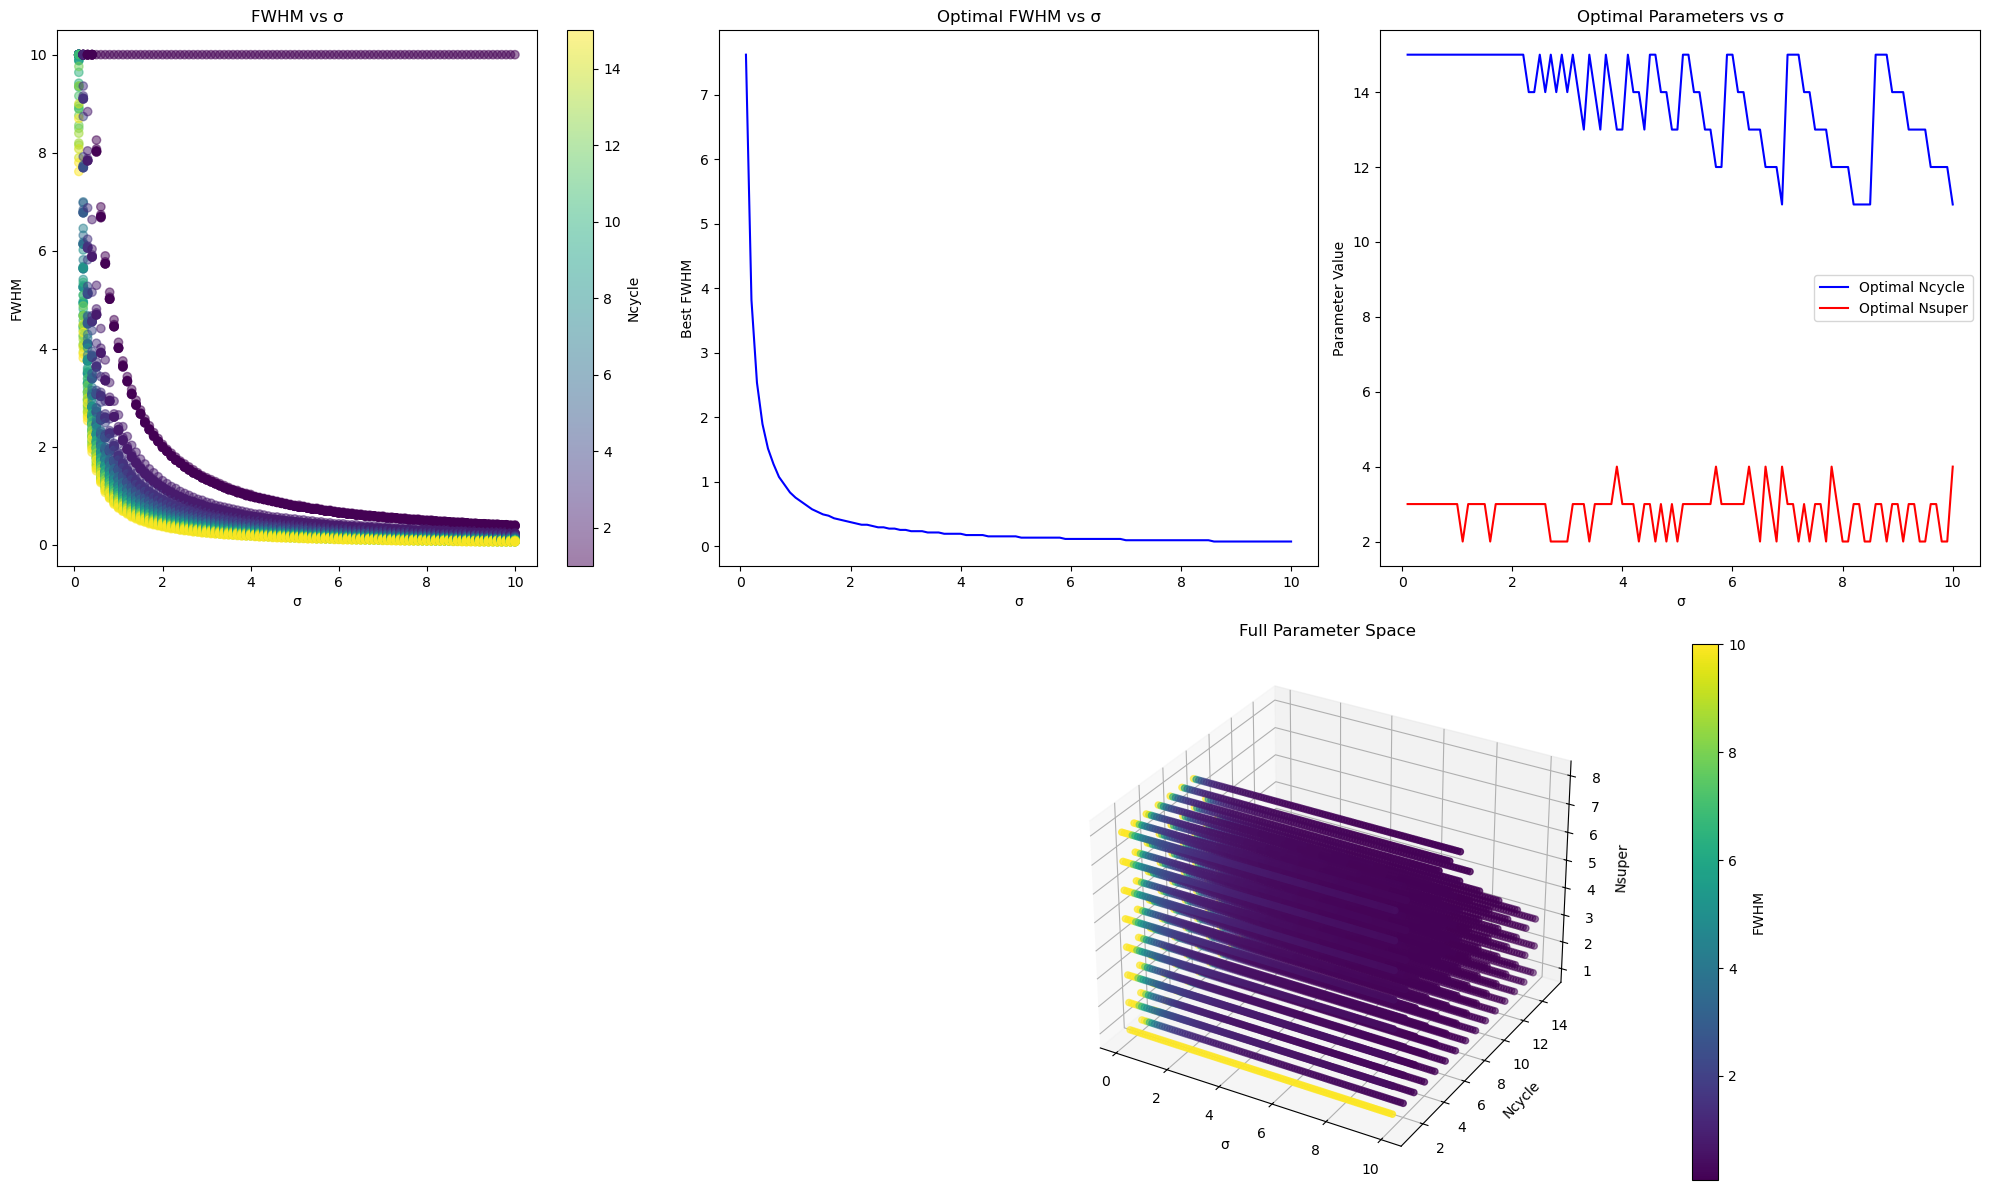

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

def rodeo_probability(delta_E, sigma, Ncycle):
    return ((1 + np.exp(-(delta_E**2) * sigma**2 / 2)) / 2)**Ncycle

def rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper):
    prob = 0
    for n in range(2**Nsuper + 1):
        term = (1 / 2**(2*Nsuper-1)) * (2**Nsuper - n)
        exponent = -(delta_E**2 * sigma**2 * n**2) / (2**(2*Nsuper-1))
        prob += term * np.exp(exponent)
    base_prob = prob - 1/2**Nsuper
    return base_prob**Ncycle

def calculate_fwhm(x, y):
    half_max = np.max(y) / 2
    indices = np.where(y >= half_max)[0]
    if len(indices) > 0:
        return x[indices[-1]] - x[indices[0]]
    return np.inf

def parameter_sweep_with_sigma(sigma_range, max_Ncycle, max_Nsuper, time_constraint=40):
    delta_E = np.linspace(-5, 5, 1000)
    
    results = []
    global_best = {'FWHM': np.inf}
    
    for sigma in sigma_range:
        for Ncycle in range(1, max_Ncycle + 1):
            for Nsuper in range(1, max_Nsuper + 1):
                total_time = Ncycle * (1 + Nsuper/2)
                
                if total_time < time_constraint:
                    p_lasso = rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper)
                    fwhm = calculate_fwhm(delta_E, p_lasso)
                    peak_height = np.max(p_lasso)
                    
                    result = {
                        'sigma': sigma,
                        'Ncycle': Ncycle,
                        'Nsuper': Nsuper,
                        'FWHM': fwhm,
                        'total_time': total_time,
                        'peak_height': peak_height
                    }
                    results.append(result)
                    
                    # Update global best if this is better
                    if fwhm < global_best['FWHM']:
                        global_best = result
    
    return results, global_best

def plot_sigma_analysis(sigma_range=np.arange(0.1, 10.1, 0.1), max_Ncycle=15, max_Nsuper=8):
    # Perform parameter sweep
    results, global_best = parameter_sweep_with_sigma(sigma_range, max_Ncycle, max_Nsuper)
    
    # Convert results to arrays for easier plotting
    results_array = np.array([(r['sigma'], r['Ncycle'], r['Nsuper'], r['FWHM'], r['total_time'], r['peak_height']) 
                             for r in results])
    sigmas, Ncycles, Nsupers, FWHMs, total_times, peak_heights = results_array.T
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    gs = plt.GridSpec(2, 3)
    
    # 1. FWHM vs sigma (colored by Ncycle)
    ax1 = fig.add_subplot(gs[0, 0])
    scatter1 = ax1.scatter(sigmas, FWHMs, c=Ncycles, cmap='viridis', alpha=0.5)
    ax1.set_xlabel('σ')
    ax1.set_ylabel('FWHM')
    ax1.set_title('FWHM vs σ')
    plt.colorbar(scatter1, ax=ax1, label='Ncycle')
    
    # 2. Best FWHM for each sigma
    ax2 = fig.add_subplot(gs[0, 1])
    min_fwhms = []
    for sig in sigma_range:
        mask = (sigmas == sig)
        min_fwhms.append(np.min(FWHMs[mask]))
    ax2.plot(sigma_range, min_fwhms, 'b-')
    ax2.set_xlabel('σ')
    ax2.set_ylabel('Best FWHM')
    ax2.set_title('Optimal FWHM vs σ')
    
    # 3. Optimal parameters for each sigma
    ax3 = fig.add_subplot(gs[0, 2])
    optimal_Ncycles = []
    optimal_Nsupers = []
    for sig in sigma_range:
        mask = (sigmas == sig)
        best_idx = np.argmin(FWHMs[mask])
        optimal_Ncycles.append(Ncycles[mask][best_idx])
        optimal_Nsupers.append(Nsupers[mask][best_idx])
    ax3.plot(sigma_range, optimal_Ncycles, 'b-', label='Optimal Ncycle')
    ax3.plot(sigma_range, optimal_Nsupers, 'r-', label='Optimal Nsuper')
    ax3.set_xlabel('σ')
    ax3.set_ylabel('Parameter Value')
    ax3.set_title('Optimal Parameters vs σ')
    ax3.legend()
    
    # 4. 3D scatter plot of parameter space
    ax4 = fig.add_subplot(gs[1, :], projection='3d')
    scatter = ax4.scatter(sigmas, Ncycles, Nsupers, c=FWHMs, cmap='viridis')
    ax4.set_xlabel('σ')
    ax4.set_ylabel('Ncycle')
    ax4.set_zlabel('Nsuper')
    plt.colorbar(scatter, ax=ax4, label='FWHM')
    ax4.set_title('Full Parameter Space')
    
    plt.tight_layout()
    
    # Print global optimal parameters
    print("\nGlobal Optimal Parameters:")
    for key, value in global_best.items():
        print(f"{key}: {value:.3f}")
    
    return fig, global_best

# Run the analysis
if __name__ == "__main__":
    fig, global_best = plot_sigma_analysis()
    plt.show()


Global Optimal Parameters:
σ: 8.600
Ncycle: 15
Nsuper: 3
FWHM: 0.070
Total Time: 37.500
Peak Height: 0.991


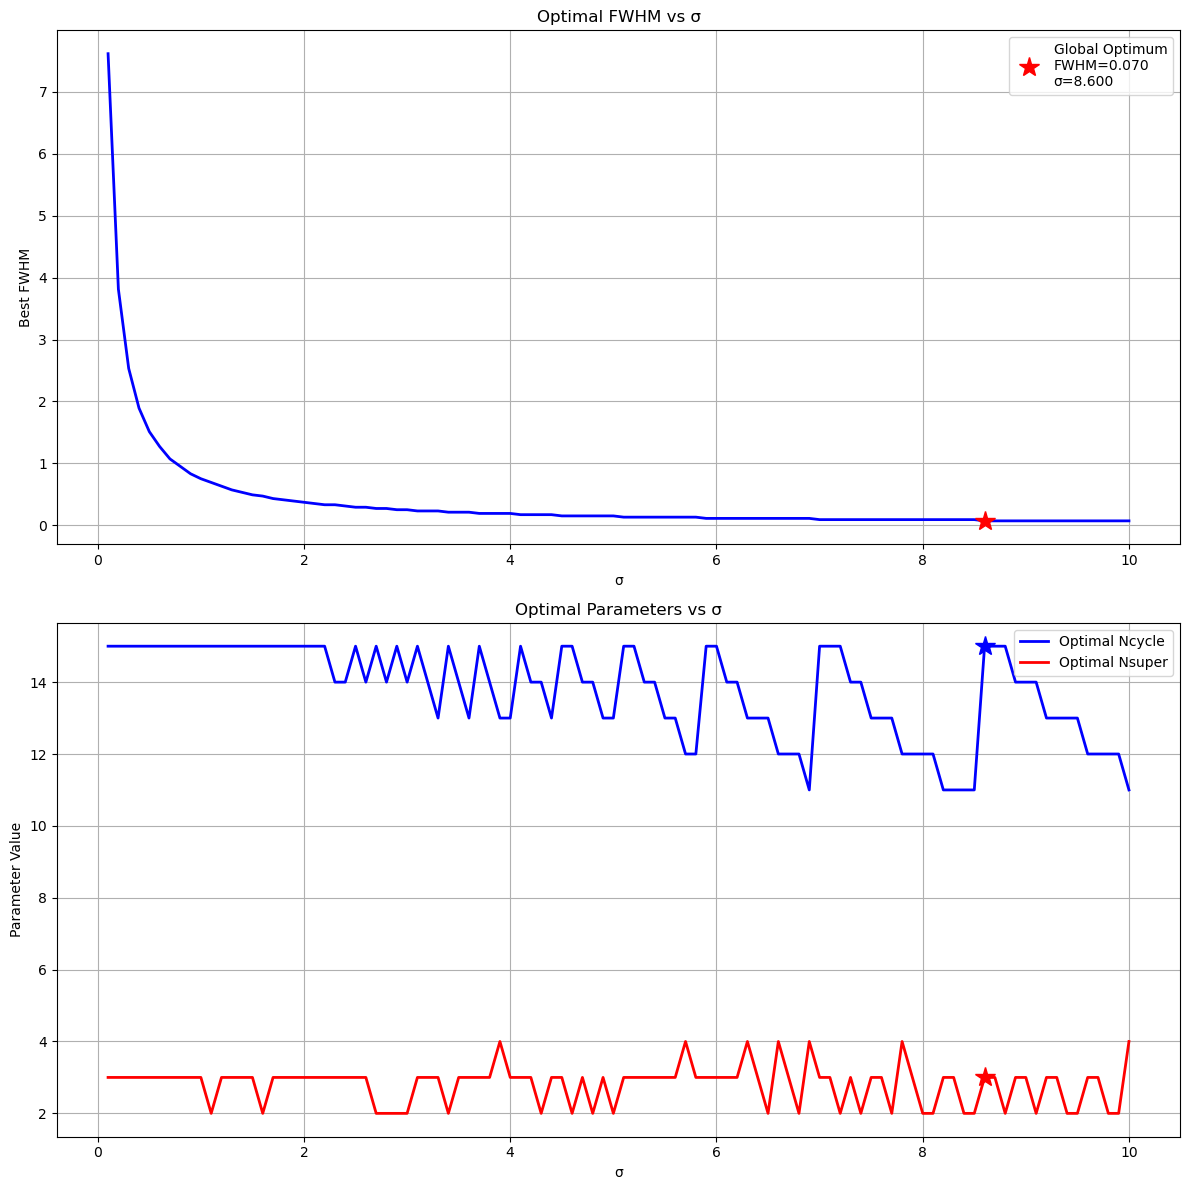

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def rodeo_probability(delta_E, sigma, Ncycle):
    return ((1 + np.exp(-(delta_E**2) * sigma**2 / 2)) / 2)**Ncycle

def rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper):
    prob = 0
    for n in range(2**Nsuper + 1):
        term = (1 / 2**(2*Nsuper-1)) * (2**Nsuper - n)
        exponent = -(delta_E**2 * sigma**2 * n**2) / (2**(2*Nsuper-1))
        prob += term * np.exp(exponent)
    base_prob = prob - 1/2**Nsuper
    return base_prob**Ncycle

def calculate_fwhm(x, y):
    half_max = np.max(y) / 2
    indices = np.where(y >= half_max)[0]
    if len(indices) > 0:
        return x[indices[-1]] - x[indices[0]]
    return np.inf

def parameter_sweep_with_sigma(sigma_range, max_Ncycle, max_Nsuper, time_constraint=40):
    delta_E = np.linspace(-5, 5, 1000)
    
    results = []
    global_best = {'FWHM': np.inf}
    
    for sigma in sigma_range:
        best_for_sigma = {'FWHM': np.inf}
        
        for Ncycle in range(1, max_Ncycle + 1):
            for Nsuper in range(1, max_Nsuper + 1):
                total_time = Ncycle * (1 + Nsuper/2)
                
                if total_time < time_constraint:
                    p_lasso = rodeo_lasso_probability(delta_E, sigma, Ncycle, Nsuper)
                    fwhm = calculate_fwhm(delta_E, p_lasso)
                    peak_height = np.max(p_lasso)
                    
                    result = {
                        'sigma': sigma,
                        'Ncycle': Ncycle,
                        'Nsuper': Nsuper,
                        'FWHM': fwhm,
                        'total_time': total_time,
                        'peak_height': peak_height
                    }
                    
                    # Update best for this sigma
                    if fwhm < best_for_sigma['FWHM']:
                        best_for_sigma = result
                    
                    # Update global best
                    if fwhm < global_best['FWHM']:
                        global_best = result
        
        # Store best result for this sigma
        results.append(best_for_sigma)
    
    return results, global_best

def plot_sigma_analysis(sigma_range=np.arange(0.1, 10.1, 0.1), max_Ncycle=15, max_Nsuper=8):
    # Perform parameter sweep
    results, global_best = parameter_sweep_with_sigma(sigma_range, max_Ncycle, max_Nsuper)
    
    # Extract data for plotting
    sigmas = [r['sigma'] for r in results]
    fwhms = [r['FWHM'] for r in results]
    ncycles = [r['Ncycle'] for r in results]
    nsupers = [r['Nsuper'] for r in results]
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot 1: Best FWHM for each sigma
    ax1.plot(sigmas, fwhms, 'b-', linewidth=2)
    ax1.set_xlabel('σ')
    ax1.set_ylabel('Best FWHM')
    ax1.set_title('Optimal FWHM vs σ')
    ax1.grid(True)
    
    # Add marker for global optimum
    ax1.plot(global_best['sigma'], global_best['FWHM'], 'r*', markersize=15, 
             label=f"Global Optimum\nFWHM={global_best['FWHM']:.3f}\nσ={global_best['sigma']:.3f}")
    ax1.legend()
    
    # Plot 2: Optimal parameters for each sigma
    ax2.plot(sigmas, ncycles, 'b-', linewidth=2, label='Optimal Ncycle')
    ax2.plot(sigmas, nsupers, 'r-', linewidth=2, label='Optimal Nsuper')
    ax2.set_xlabel('σ')
    ax2.set_ylabel('Parameter Value')
    ax2.set_title('Optimal Parameters vs σ')
    ax2.grid(True)
    
    # Add markers for global optimum parameters
    ax2.plot(global_best['sigma'], global_best['Ncycle'], 'b*', markersize=15)
    ax2.plot(global_best['sigma'], global_best['Nsuper'], 'r*', markersize=15)
    ax2.legend()
    
    plt.tight_layout()
    
    # Print global optimal parameters
    print("\nGlobal Optimal Parameters:")
    print(f"σ: {global_best['sigma']:.3f}")
    print(f"Ncycle: {global_best['Ncycle']:.0f}")
    print(f"Nsuper: {global_best['Nsuper']:.0f}")
    print(f"FWHM: {global_best['FWHM']:.3f}")
    print(f"Total Time: {global_best['total_time']:.3f}")
    print(f"Peak Height: {global_best['peak_height']:.3f}")
    
    return fig, global_best

# Run the analysis
if __name__ == "__main__":
    fig, global_best = plot_sigma_analysis()
    plt.show()